In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import spearmanr
import statsmodels.api as sm
from statsmodels.formula.api import ols

import warnings
# 忽略所有警告
warnings.filterwarnings("ignore")

In [20]:
pip install statsmodels


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [21]:
pip install scipy


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [22]:
filename = '../002Data/preprocessing data.csv'
data = pd.read_csv(filename)
data['室厅数'] = data['室厅数'].str.replace('室', '')

In [23]:
import matplotlib.pyplot as plt
from matplotlib import font_manager

font_path = '../003Attachments/test.ttf'  
font_prop = font_manager.FontProperties(fname=font_path)


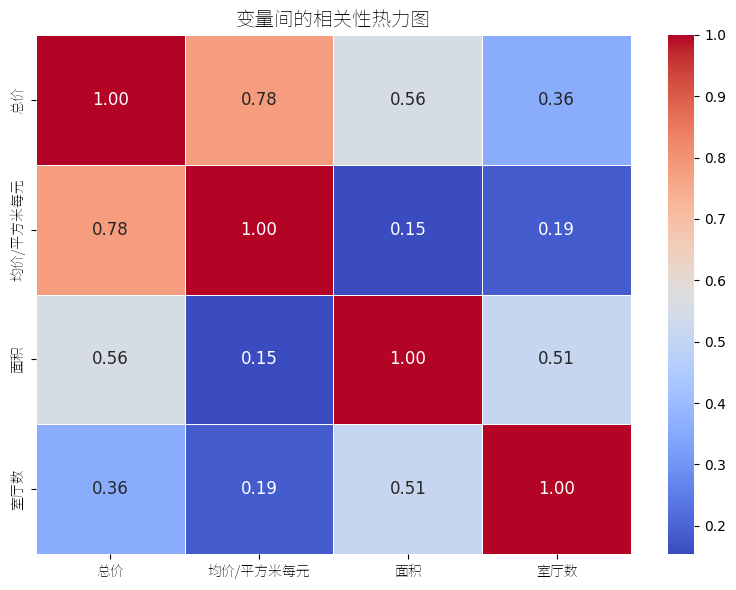

In [24]:
# 直接将室厅数转换为数值类型，不创建新的列
data['室厅数'] = data['室厅数'].astype(float)

# 选择需要分析的列
new_df = data[['总价', '均价/平方米每元', '面积', '室厅数']]

# 计算Spearman相关系数
corr_df = new_df.corr(method='spearman')

# 创建热力图
plt.figure(figsize=(8, 6))
ax = sns.heatmap(corr_df, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5,
                annot_kws={"size": 12})

# 设置标题和标签（使用中文字体）
plt.title("变量间的相关性热力图", fontproperties=font_prop, size=14)

# 设置坐标轴标签的字体
plt.xticks(fontproperties=font_prop, size=10)
plt.yticks(fontproperties=font_prop, size=10)

# 调整布局，确保所有标签都能显示
plt.tight_layout()

# 显示图表
plt.show()

In [25]:
from scipy.stats import chi2_contingency
import pandas as pd

# 根据表格中显示的列名调整特征列表
class_data = ['是否是人车分流', '是否是品牌房企', '是否是车位充足', '是否是国央企', 
              '是否是绿化率高', '是否是低总价', '是否是佛山楼盘' , '是否是低单价',]

# 对对数总价进行卡方检验
print("===== 对数总价的卡方检验结果 =====")
for i in class_data:
    contingency_table = pd.crosstab(data[i], data['对数总价'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    if p < 0.1:
        print(f"{i}与对数总价的关联p值: {p:.6f}")

===== 对数总价的卡方检验结果 =====
是否是品牌房企与对数总价的关联p值: 0.057895
是否是国央企与对数总价的关联p值: 0.078658
是否是低总价与对数总价的关联p值: 0.028873
是否是低单价与对数总价的关联p值: 0.069689


In [26]:
# 对对数均价进行卡方检验
print("\n===== 对数均价/平方米每元的卡方检验结果 =====")
for i in class_data:
    contingency_table = pd.crosstab(data[i], data['对数均价/平方米每元'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    if p < 0.1:
        print(f"{i}与对数均价的关联p值: {p:.6f}")


===== 对数均价/平方米每元的卡方检验结果 =====
是否是品牌房企与对数均价的关联p值: 0.000019
是否是车位充足与对数均价的关联p值: 0.009524
是否是国央企与对数均价的关联p值: 0.000000
是否是低总价与对数均价的关联p值: 0.000036
是否是佛山楼盘与对数均价的关联p值: 0.000000
是否是低单价与对数均价的关联p值: 0.000000


In [27]:
data = data.copy()

data.sample()

,标题,地区,位置,类型,均价/平方米每元,室厅数,面积,总价,对数均价/平方米每元,对数总价,对数面积,是否是人车分流,是否是车位充足,是否是品牌房企,是否是绿化率高,是否是低总价,是否是国央企,是否是佛山楼盘,是否是低单价
35,嘉御豪庭,增城,石滩镇,在售,12600,3.0,100.0,133.5,9.441452,4.894101,4.60517,1,0,0,0,0,0,0,1


In [28]:
# 总价模型
X = data[['对数均价/平方米每元', '对数面积', '室厅数', '是否是人车分流', '是否是品牌房企', '是否是车位充足', '是否是国央企', '是否是绿化率高', '是否是低总价', '是否是佛山楼盘', '是否是低单价']] 
y = data['对数总价'] 
X = sm.add_constant(X) 
model = sm.OLS(y, X) 
result = model.fit() 
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   对数总价   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     297.7
Date:                Sat, 08 Mar 2025   Prob (F-statistic):          5.80e-249
Time:                        21:54:51   Log-Likelihood:                -275.09
No. Observations:                 680   AIC:                             574.2
Df Residuals:                     668   BIC:                             628.4
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.8692      0.322    -27.528      0.0

In [29]:
# 计算总价模型的标准化系数
standardized_coef = result.params[1:] * (X.iloc[:, 1:].std() / y.std())
coef_df = pd.DataFrame({'变量': X.columns[1:], '标准化系数': standardized_coef})
coef_df = coef_df.sort_values('标准化系数', ascending=False)
print("\n===== 对数总价模型的特征重要性 =====")
print(coef_df)


===== 对数总价模型的特征重要性 =====
                    变量     标准化系数
对数均价/平方米每元  对数均价/平方米每元  0.682953
对数面积              对数面积  0.570128
是否是佛山楼盘        是否是佛山楼盘  0.059551
是否是车位充足        是否是车位充足  0.050885
是否是低单价          是否是低单价  0.048712
是否是绿化率高        是否是绿化率高  0.047320
是否是国央企          是否是国央企  0.017728
是否是品牌房企        是否是品牌房企  0.005658
是否是人车分流        是否是人车分流  0.004273
是否是低总价          是否是低总价 -0.028469
室厅数                室厅数 -0.127124


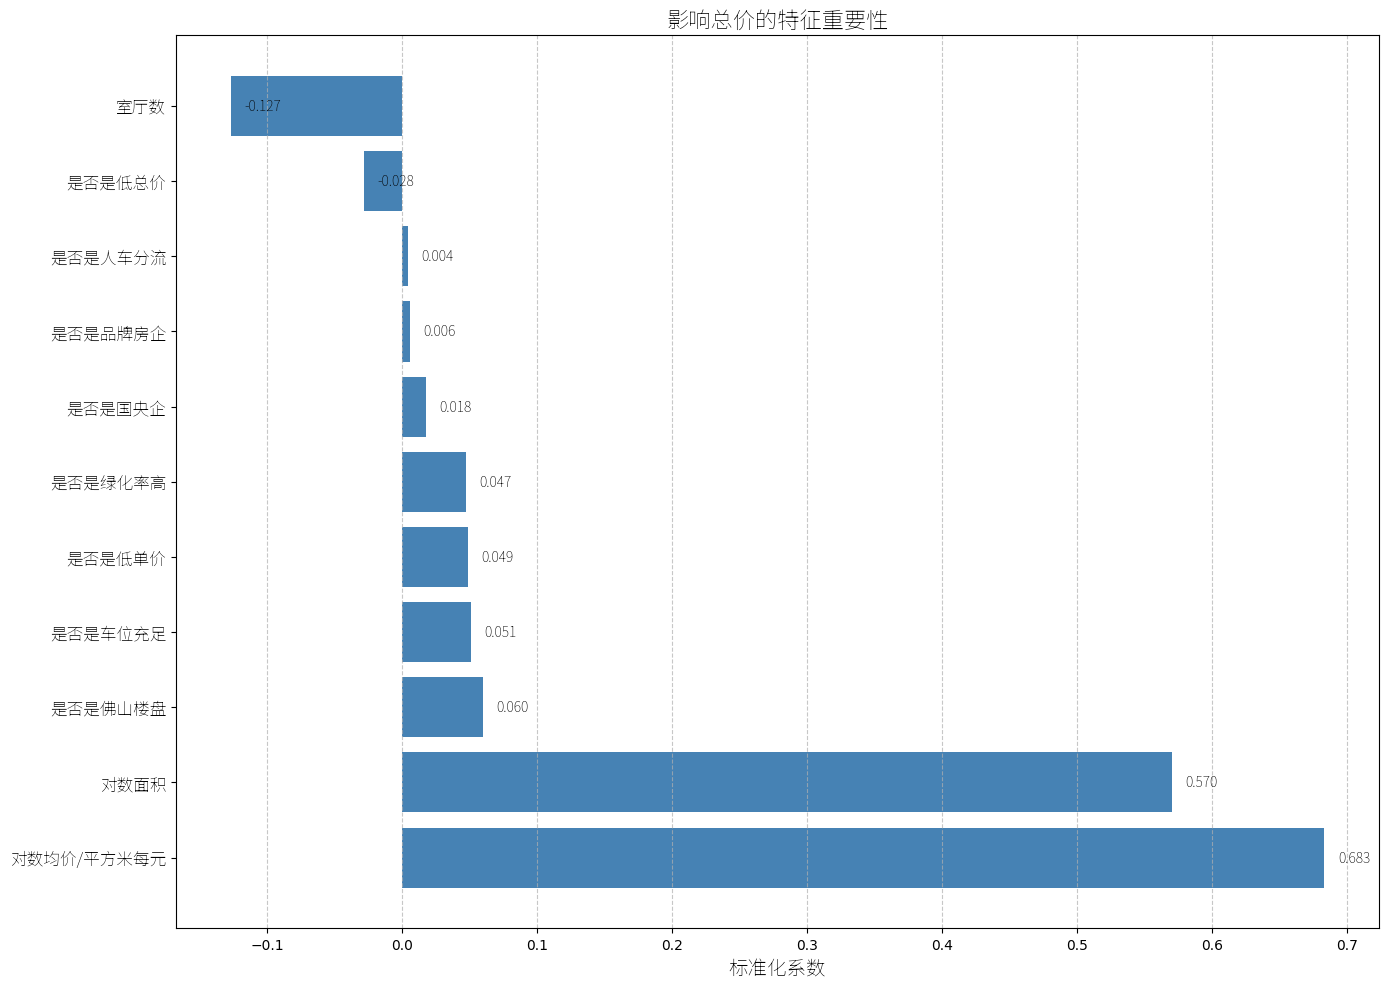

In [30]:
# 可视化总价模型的标准化系数
plt.figure(figsize=(14, 10)) 

# 绘制水平条形图
ax = plt.barh(coef_df['变量'], coef_df['标准化系数'], color='steelblue')

plt.title('影响总价的特征重要性', fontproperties=font_prop, size=16)
plt.xlabel('标准化系数', fontproperties=font_prop, size=14)

plt.yticks(fontproperties=font_prop, size=12)
plt.subplots_adjust(left=0.3, right=0.95)

for i, v in enumerate(coef_df['标准化系数']):
    plt.text(v + 0.01, i, f'{v:.3f}', fontproperties=font_prop, 
             va='center', fontsize=10)

plt.grid(axis='x', linestyle='--', alpha=0.7)

# 确保所有元素可见
plt.tight_layout()

# 保存图表
# plt.savefig('特征重要性.png', dpi=300, bbox_inches='tight')

plt.show()

In [31]:
# 均价模型
X = data[['对数总价', '对数面积', '室厅数', '是否是人车分流', '是否是品牌房企', 
          '是否是车位充足', '是否是国央企', '是否是绿化率高', '是否是低总价', 
          '是否是佛山楼盘', '是否是低单价']]
X = sm.add_constant(X)
y = data['对数均价/平方米每元']
model = sm.OLS(y, X)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:             对数均价/平方米每元   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     210.6
Date:                Sat, 08 Mar 2025   Prob (F-statistic):          1.07e-208
Time:                        21:54:51   Log-Likelihood:                -135.35
No. Observations:                 680   AIC:                             294.7
Df Residuals:                     668   BIC:                             349.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.2931      0.133     70.031      0.0

In [32]:
# 计算标准化系数
standardized_coef = result.params[1:] * (X.iloc[:, 1:].std() / y.std())  # 跳过常数项
coef_df = pd.DataFrame({'变量': X.columns[1:], '标准化系数': standardized_coef})
coef_df = coef_df.sort_values('标准化系数', ascending=False)
print("\n===== 对数均价模型的特征重要性 =====")
print(coef_df)


===== 对数均价模型的特征重要性 =====
              变量     标准化系数
对数总价        对数总价  0.902270
室厅数          室厅数  0.128583
是否是国央企    是否是国央企  0.081978
是否是低总价    是否是低总价  0.047213
是否是品牌房企  是否是品牌房企  0.037189
是否是车位充足  是否是车位充足  0.006528
是否是人车分流  是否是人车分流 -0.009317
是否是绿化率高  是否是绿化率高 -0.025079
是否是佛山楼盘  是否是佛山楼盘 -0.129418
是否是低单价    是否是低单价 -0.161526
对数面积        对数面积 -0.496171


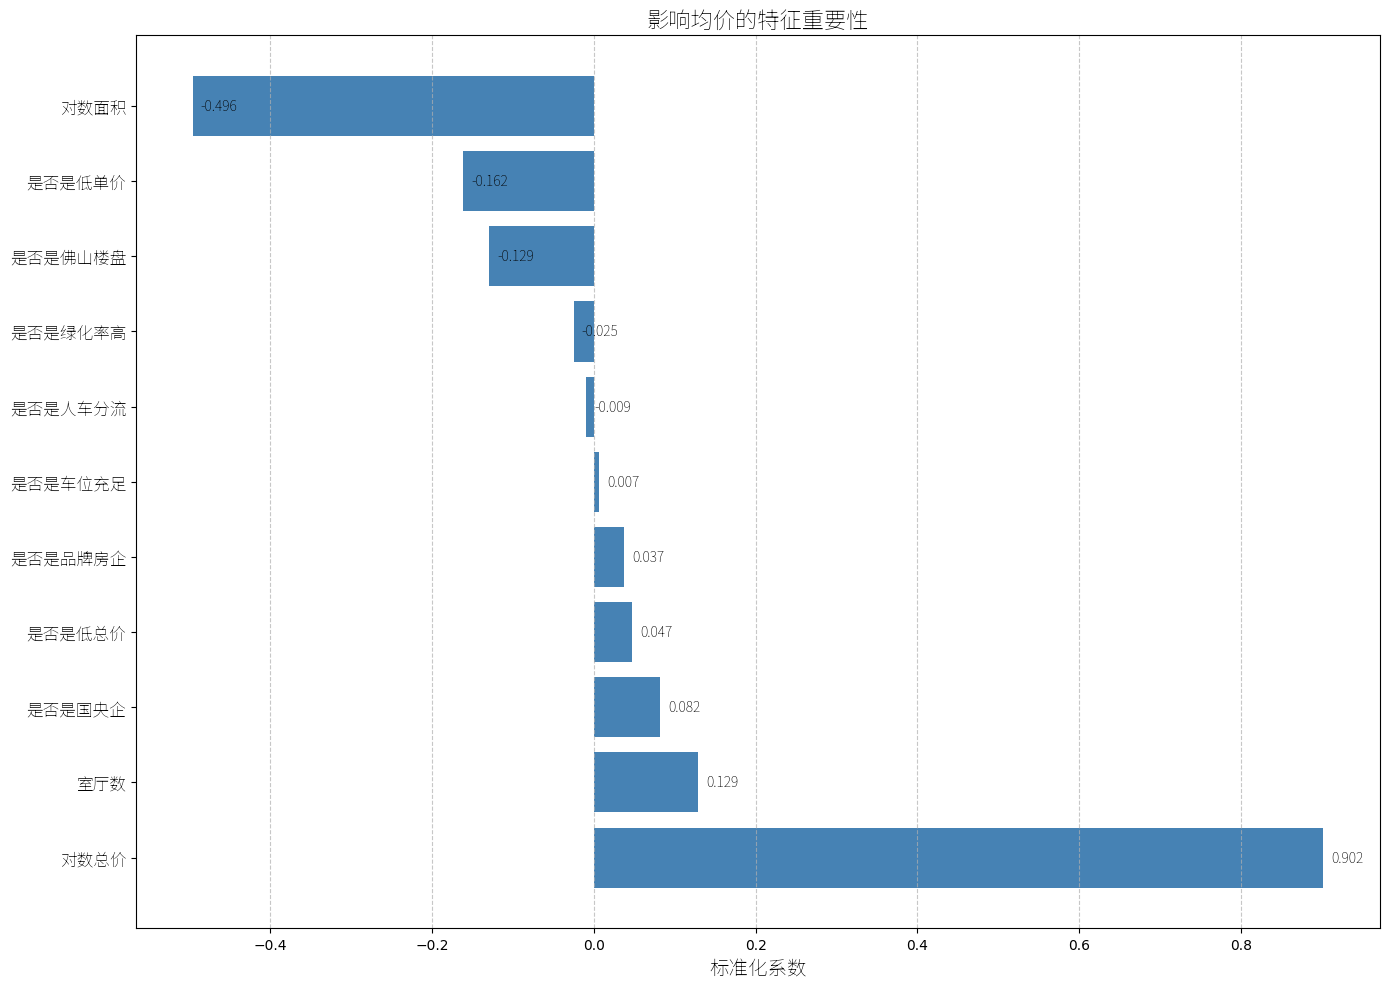

In [ ]:
# 可视化均价模型的标准化系数
plt.figure(figsize=(14, 10))  

# 绘制水平条形图
plt.barh(coef_df['变量'], coef_df['标准化系数'], color='steelblue')

plt.title('影响均价的特征重要性', fontproperties=font_prop, size=16)
plt.xlabel('标准化系数', fontproperties=font_prop, size=14)

plt.yticks(fontproperties=font_prop, size=12)

# 增加左侧边距
plt.subplots_adjust(left=0.3, right=0.95)

# 添加数值标签，直接在条形上显示值
for i, v in enumerate(coef_df['标准化系数']):
    plt.text(v + 0.01, i, f'{v:.3f}', fontproperties=font_prop, 
             va='center', fontsize=10)

# 设置网格线
plt.grid(axis='x', linestyle='--', alpha=0.7)

# 确保所有元素可见
plt.tight_layout()

# 显示图表
plt.show()